# Estudio comparativo de métodos de agrupación (HDBSCAN, GMM)

**Universidad Nacional de Colombia**

*David Fernando Parada Brijalba,* 
*Rosmer Manuel Vargas Contreras y*
*Joan Sebastian Franco Jimenez*

## Introducción

Los algoritmos de agrupamiento de los datos más conocidos, no siempre generan resultados correctos en contextos de alta dimensionalidad o bajo la presencia de datos atípicos los cuales pueden mostrar una alteración en la forma natural en la cual los datos se agrupan. El agrupamiento espacial basado en densidad de aplicaciones con ruido jerárquico o HDBSCAN por sus siglas en inglés, es un algoritmo de agrupamiento de datos basado en densidades, dado que construye los grupos de datos estimando las distribuciones de densidad de cada uno de ellos, comenzando por los nodos correspondientes. 

## Nota Historica

El algoritmo HDBSCAN, desarrollado por Campello, Moulavi, and Sander. en el 2013 como una mejora a su predeseror, el DBSCAN, el cual fue propuesto por Martin Ester, Hans-Peter Kriegel, Jörg Sander y Xiaowei Xu en 1996

## Entendiendo el HDBSCAN y la agrupación en clústeres basada en la densidad

*Nota:* Esta sección esta basada en la lectura de Towards Data Science por [Pepe Berba](https://towardsdatascience.com/understanding-hdbscan-and-density-based-clustering-121dbee1320e)

El objetivo principal de esta sección es mostrar los conceptos clave que te ayudarán a comprender cómo y por qué funciona el algoritmo de agrupamiento HDBSCAN.
 
Recordemos que el algoritmo HDBSCAN es una técnica de agrupamiento robusta y basada en densidades, así que como tal, podemos advertir que a priori no tenemos ningún supuesto que verificar.

Empecemos por lo más alto. Antes incluso de describir nuestro algoritmo de agrupamiento, debemos preguntarnos, "¿qué tipo de datos estamos tratando de agrupar?" Queremos tener la menor cantidad posible de suposiciones sobre nuestros datos. Quizás las únicas suposiciones que podemos hacer con seguridad son:

1. Hay ruido en nuestros datos
2. Hay grupos en nuestros datos que esperamos descubrir



In [63]:
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams
#plt.style.use('seaborn')
rcParams['figure.figsize'] = 9, 6

from IPython.display import Image


In [58]:
data = np.load('C:/Users/dfdop/Documents/Data-Mining/HDBSCAN-y-GMM/clusterable_data.npy')

Con el fin de motivar la explicación del HDBSCAN, arrancaremos mostrando los datos obtenidos de *chaca chaca* los cuales vemos a continuacion:

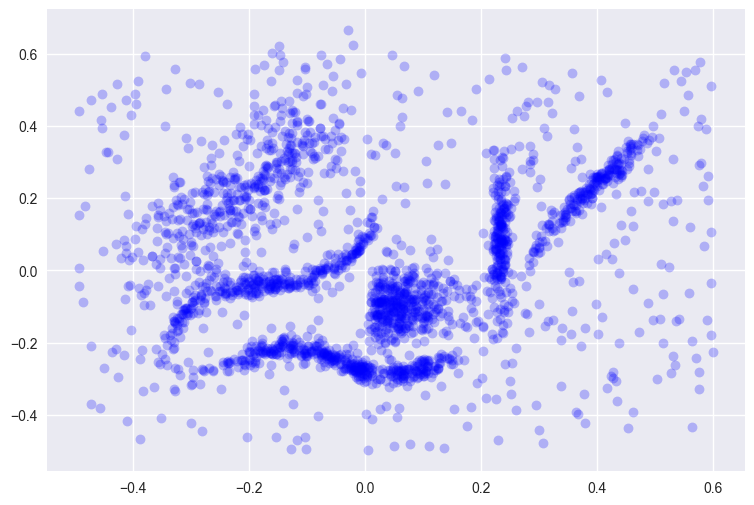

In [59]:
plt.scatter(*data.T, s=50, linewidth=0, c='b', alpha=0.25)

Este conjunto de datos tiene únicamente 2 dimensiones, lo cual lo convierte en un ejemplo fácil para detectar los clusters a simple vista. Es así que podemos identificar fácilmente "6" clusters, ahora nuestro siguiente paso es detectarlos por medio de un algoritmo de clustering.  

### K-means vs HDBSCAN

Conociendo el número esperado de grupos, ejecutamos el algoritmo clásico de K-means y comparamos las etiquetas resultantes con las obtenidas usando HDBSCAN.

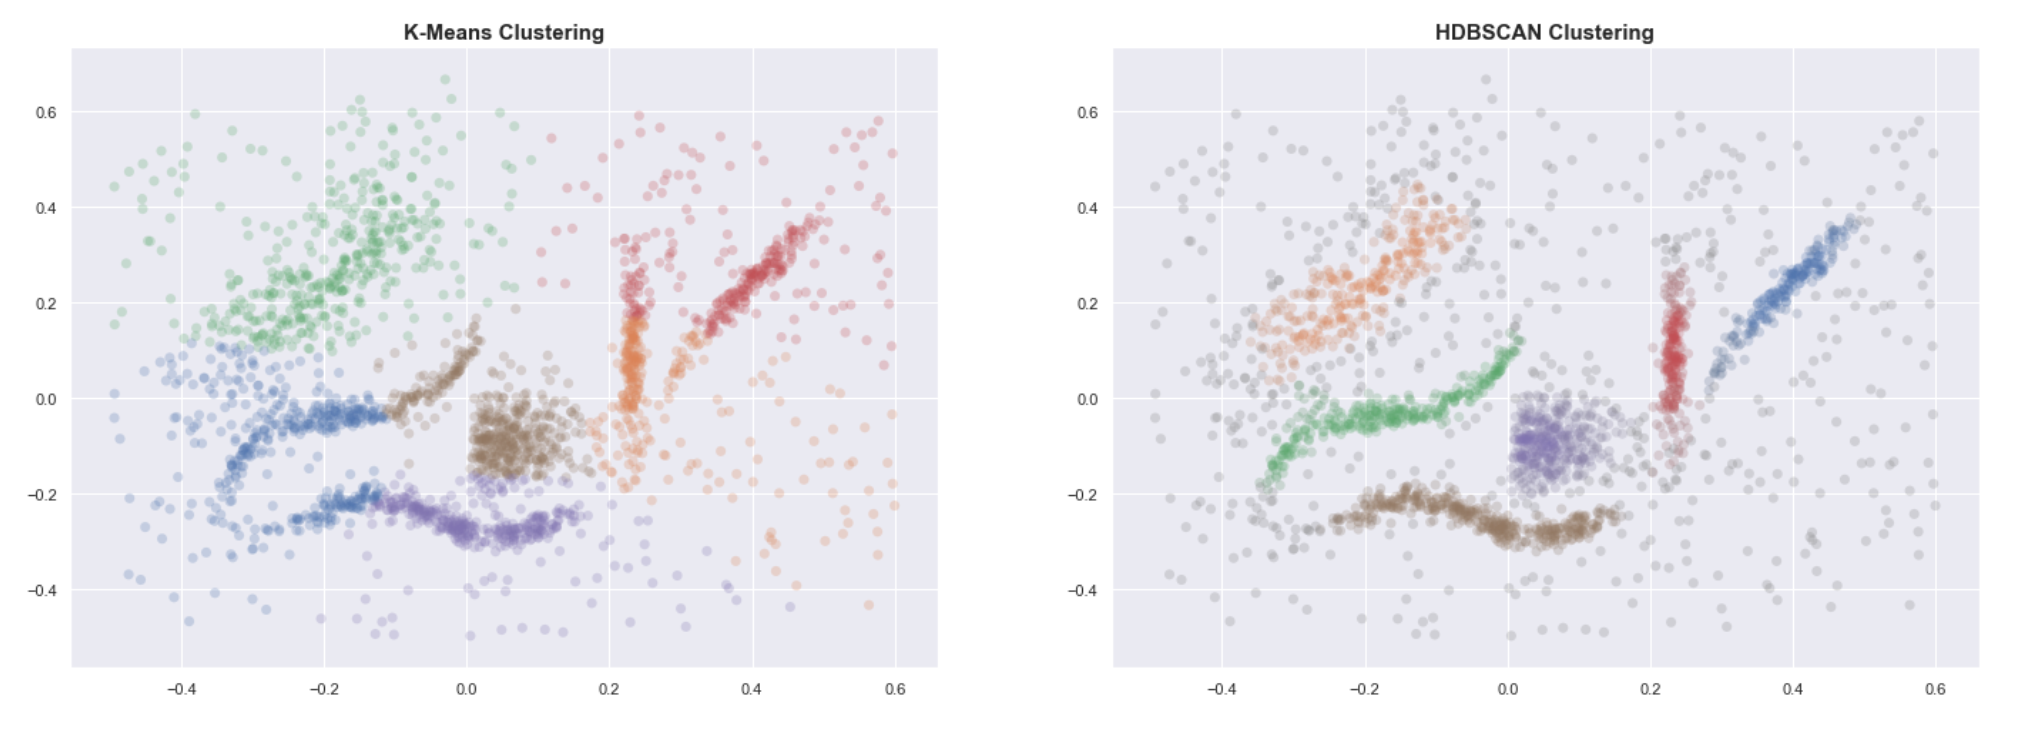

In [60]:
Image(filename = "KH.png", width = 1000, height = 400)

Incluso cuando se proporciona el número correcto de grupos, K-means claramente no logra agrupar los datos en grupos útiles. HDBSCAN, por otro lado, nos da la agrupación esperada.

### ¿Por qué el algoritmo K-Means falla?

Brevemente, **K-means tiene un desempeño deficiente porque no se cumplen los supuestos subyacentes sobre la forma de los conglomerados**; es un algoritmo paramétrico parametrizado por los centroides del grupo K, los centros de las esferas gaussianas. K-means funciona mejor cuando los clústeres son:
1. Esferícos o semi-esferícos
2. De igual tamaño
3. Con la misma densidad
4. Con mayor densidad hacia el centro de la esfera o esferoide
5. Datos no contaminados por ruido i.e., pocos o nulos datos atipicos

Tomemos prestado un ejemplo más simple de (Hastie. et al., 2009) para ilustrar cómo las K-medias pueden ser sensibles a la forma de los conglomerados. A continuación se muestran dos agrupaciones a partir de los mismos datos. A la izquierda, los datos se estandarizaron antes de la agrupación. Sin estandarización, obtenemos una agrupación "errónea".


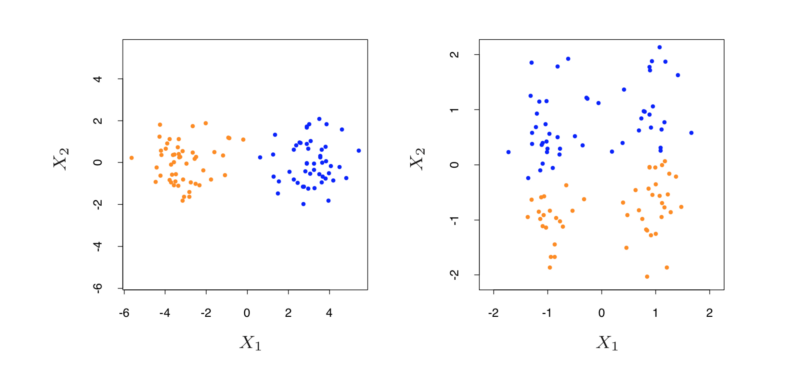

In [64]:
Image(filename = "Kmean.png")

$\textbf{Figura 1}$ (Izquierda) Clusters formados con los datos estandarizados vs (Derecha) Clusters formados con los datos sin estandarizar

### ¿Cuáles son las características de nuestros datos?

Volvemos a nuestro conjunto de datos original y simplemente describiéndolo, se vuelve obvio por qué K-means tiene dificultades. El conjunto de datos tiene:

1. Clústeres con formas arbitrarias
2. Clústeres de distintos tamaños
3. Clústeres con diferentes densidades
4. Algo de ruido y tal vez algunos valores atípicos

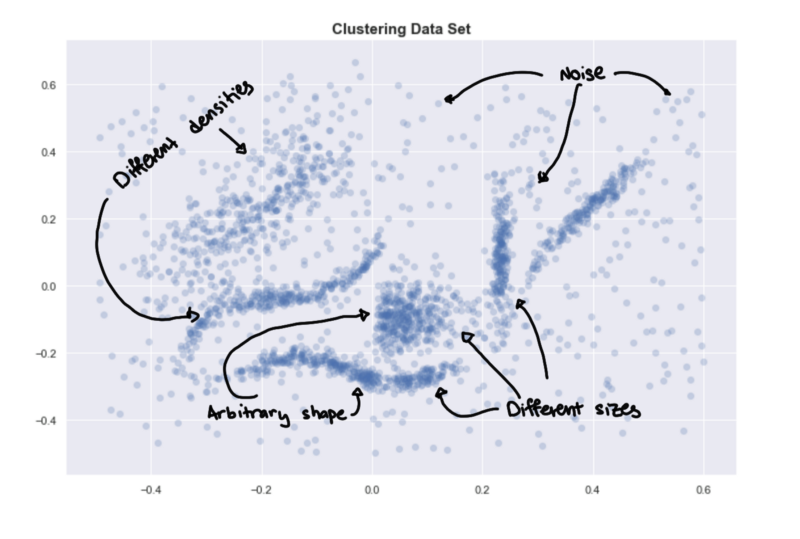

In [73]:
Image(filename = "cdata.png", width = 600, height = 400)

### Necesidad de robustez para la exploración de datos

Si bien cada una de las observaciones se puede provenir de un conjunto de datos del mundo real, cada uno de ellos puede llegar a suponer un problema para algoritmos paramétricos como K-means. Es posible que deseemos verificar si se cumplen las suposiciones de nuestros algoritmos antes de confiar en su salida. Pero verificar estas suposiciones puede ser difícil cuando se sabe poco sobre los datos. Esto es desafortunado porque uno de los usos principales de los algoritmos de agrupamiento es la exploración de datos donde todavía estamos en el proceso de comprender los datos.

Por lo tanto, un algoritmo de agrupamiento que se utilizará para la exploración de datos debe tener la menor cantidad de suposiciones posible para que los conocimientos iniciales que obtengamos sean "útiles"; tener menos suposiciones lo hace más sólido y aplicable a una gama más amplia de datos del mundo real.

### Regiones densas y modas multivariadas

Ahora que tenemos una idea de qué tipo de datos estamos tratando, exploremos las ideas centrales de HDBSCAN y cómo sobresale incluso cuando los datos tienen:

1. Clústeres de forma arbitraria
2. Clústeres con diferentes tamaños y densidades
3. Ruido

HDBSCAN utiliza un enfoque basado en la densidad que hace pocas suposiciones implícitas sobre los clústeres. Es un método no paramétrico que busca una jerarquía de conglomerados conformada por los modos multivariados de la distribución subyacente. En lugar de buscar grupos con una forma particular, busca regiones de los datos que sean más densas que el espacio circundante. La imagen mental que puedes utilizar es intentar separar las islas del mar o las montañas de sus valles.

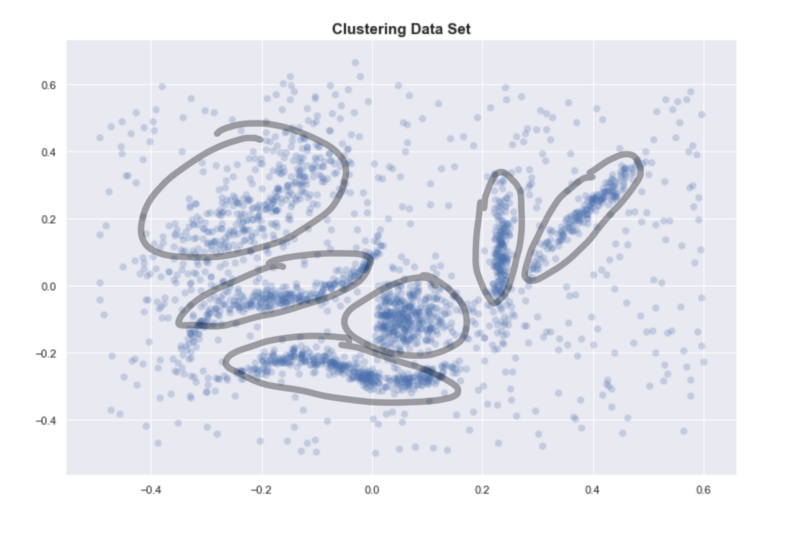

In [72]:
Image(filename = "densedta.png", width = 600, height = 400)

Una forma de definir un cluster que suele ser consistente con nuestra noción intuitiva de conglomerados es: regiones muy densas separadas por regiones dispersas.

La siguiente grafica obtenida con datos simulados, muestra claramente 3 clusters

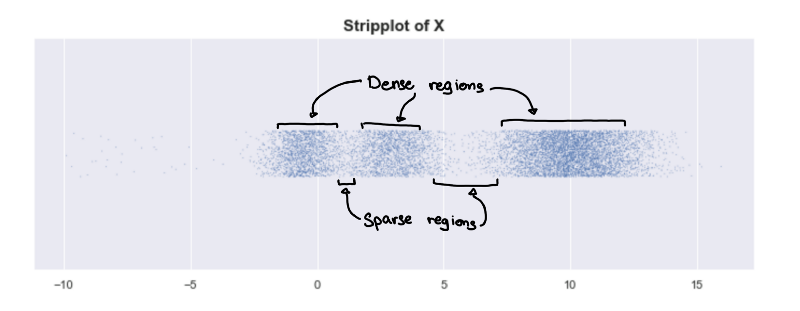

In [67]:
Image(filename = "3dense.png")

### En búsqueda de la distribución subyacente

$X$ son datos simulados de una mezcla de distribuciones normales, y por lo tanto somos capaces de graficar la distribución exacta de $X$.

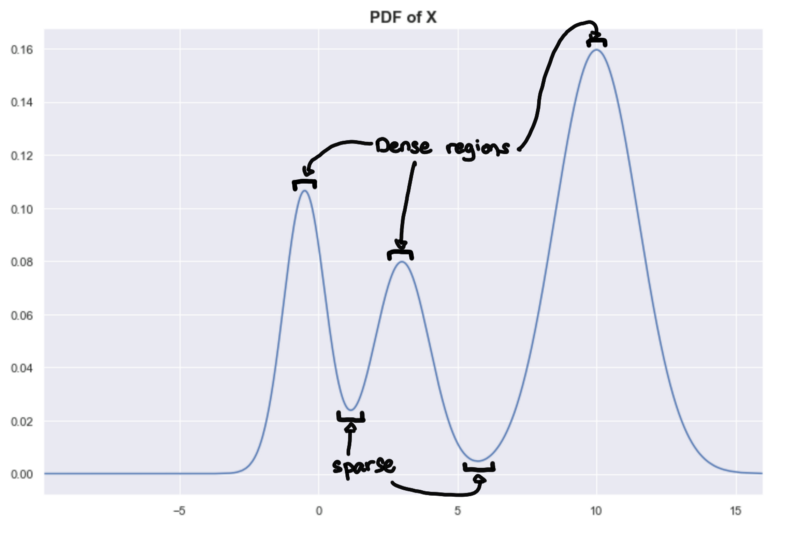

In [71]:
Image(filename = "dise.png", width = 600, height = 400)

Los picos corresponden a las regiones más densas y los valles corresponden a las regiones dispersas. Esto nos da otra forma de enmarcar el problema suponiendo que conocemos la distribución subyacente, los conglomerados son regiones altamente probables separadas por regiones improbables. Imagine las distribuciones de probabilidad de dimensiones superiores formando un paisaje de montañas y valles, donde las montañas son sus clusters.

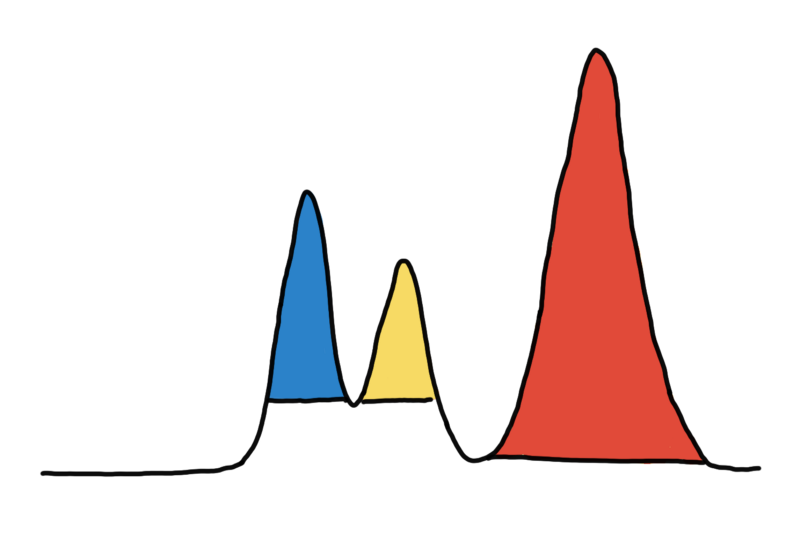

In [70]:
Image(filename = "dense1.png", width = 600, height = 400)


Para aquellos que no estén tan familiarizados con terminos estadísticos, las dos afirmaciones siguientes son prácticamente iguales:

1. regiones muy densas separadas por regiones escasas
2. regiones altamente probables separadas por regiones improbables

La principal diferencia esta, en que uno describe los datos a través de su distribución de probabilidad y el otro a través de una muestra aleatoria de esa distribución.

El gráfico FDP y el gráfico de strip plot de arriba son equivalentes. La FDP, función de densidad de probabilidad, se interpreta como la probabilidad de estar dentro de una pequeña región alrededor de un punto, y cuando se observa una muestra de $X$, también se puede interpretar como la densidad esperada alrededor de ese punto.

Dada la distribución subyacente, esperamos que las regiones que son más probables tiendan a tener más puntos (más densas) en una muestra aleatoria. De manera similar, dada una muestra aleatoria, puede hacer inferencias sobre la probabilidad de una región en función de la densidad empírica.

**Las regiones más densas en la muestra aleatoria corresponden a regiones más probables en las distribuciones subyacentes.**

De hecho, si observamos el histograma de una muestra aleatoria de $X$, vemos que se parece exactamente a la verdadera distribución de $X$. El histograma a veces se denomina distribución de probabilidad empírica y, con suficientes datos, esperamos que el histograma converja a la verdadera distribución subyacente.

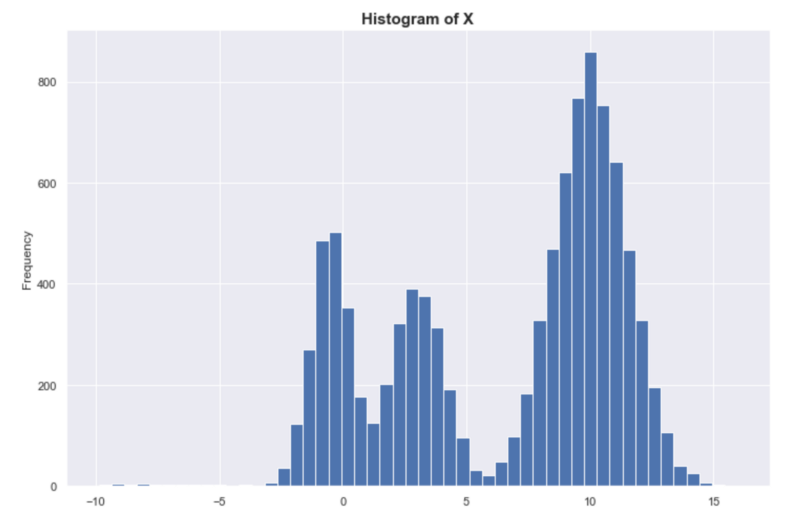

In [74]:
Image(filename = "dense2.png", width = 600, height = 400)

De nuevo, densidad = probabilidad. Más denso = más probable.

Lamentablemente, incluso con nuestra definición intuitiva de clusters como "montañas y valles", puede ser difícil saber si algo es o no un cluster único. Miremos el ejemplo a continuación donde trasladamos a la derecha una de las modas de $X$. Aunque todavía tenemos 3 picos, ¿tenemos 3 grupos? En algunos contextos, podríamos considerar 3 grupos. "Intuitivamente" decimos que solo hay 2 grupos. Entonces ¿cómo decidimos?

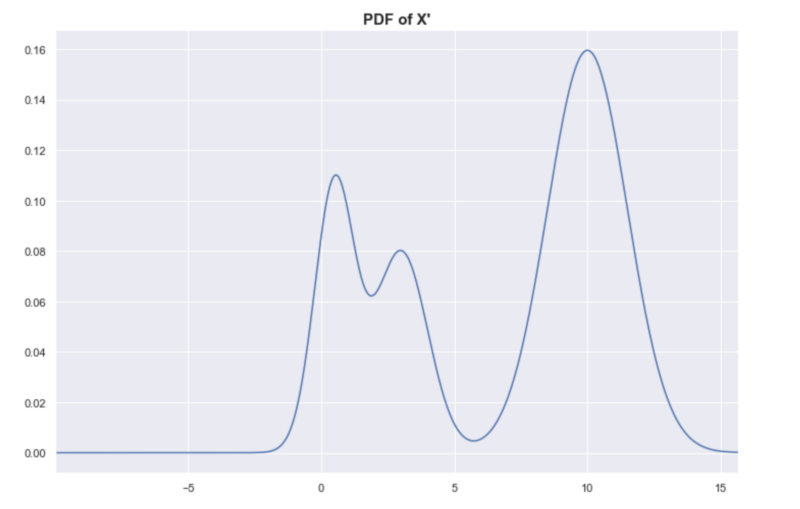

In [75]:
Image(filename = "dense3.png", width = 600, height = 400)

Al mirar el grafico *strip plot* de $X$, podemos estar un poco más seguros de que solo hay 2 grupos.

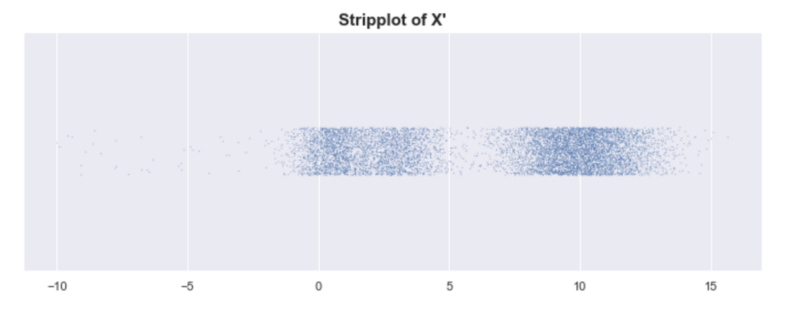

In [77]:
Image(filename = "dense4.png")

$X$ tiene 3 grupos y $X$ tiene 2 grupos. ¿En qué punto cambia el número de clusters?

Una forma de definir esto es establecer algún umbral global para el FDP de la distribución subyacente. *"Los componentes conectados de los conjuntos de niveles resultantes son sus grupos"* [1]. Esto es lo que hace el algoritmo DBSCAN, y hacerlo en múltiples niveles daría como resultado HDBSCAN [4].

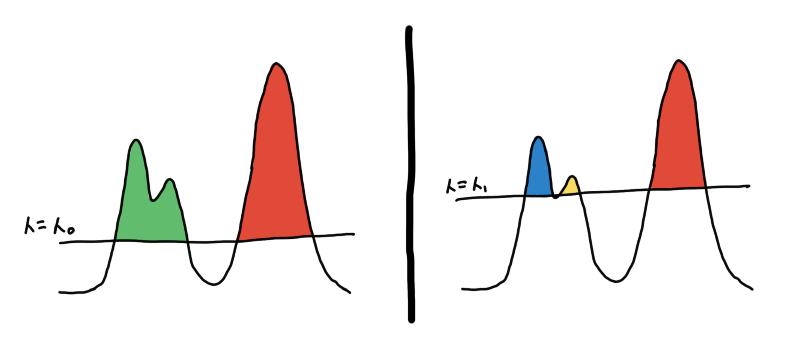

In [78]:
Image(filename = "dense5.png")

Esto puede ser atractivo por su simplicidad, ¡pero no se deje engañar! Terminamos con un hiperparámetro adicional, el umbral $\lambda$, que quizás tengamos que ajustar. Además, esto no funciona bien para grupos con diferentes densidades.

Para ayudarnos a elegir, coloreamos nuestras opciones de grupos como se muestra en la siguiente ilustración. ¿Deberíamos considerar azul y amarillo, o solo verde?

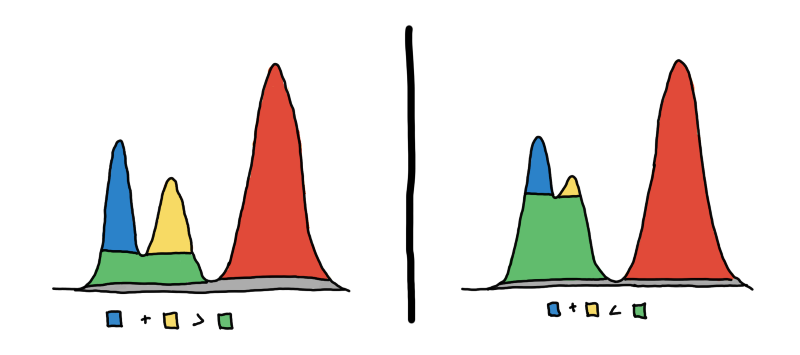

In [79]:
Image(filename = "dense6.png")

Para elegir, nos fijamos en cuál “persiste” más. ¿Los vemos más juntos o separados? Podemos cuantificar esto usando el área de las regiones coloreadas.

A la izquierda, vemos que la suma de las áreas de las regiones azul y amarilla es mayor que el área de la región verde. Esto significa que los 2 picos son más prominentes, por lo que decidimos que son dos grupos separados.

A la derecha, vemos que el área de verde es mucho más grande. Esto significa que son solo "baches" en lugar de picos. Entonces decimos que son solo un grupo.

En la literatura [2], el área de las regiones es la medida de persistencia, y el método se llama eom o exceso de masa. Un poco más formal, maximizamos la suma total de persistencia de los grupos bajo la restricción de que los grupos elegidos no se superponen.

### Construyendo la jerarquía

Al obtener múltiples conjuntos de niveles en diferentes valores de $\lambda$, obtenemos una jerarquía. Para un escenario multidimensional, imagina que los grupos son islas en medio del océano. A medida que baja el nivel del mar, las islas comenzarán a “crecer” y eventualmente las islas comenzarán a conectarse entre sí.

Para poder capturar y representar estas relaciones entre clusters (islas), lo representamos como un árbol de jerarquía. Esta representación se generaliza a dimensiones superiores y es una abstracción natural que es más fácil de representar como una estructura de datos que podemos atravesar y manipular.

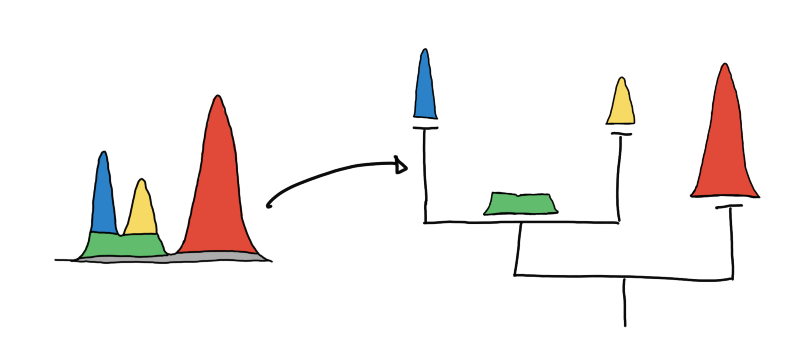

In [80]:
Image(filename = "dense7.png")

## Fundamento Matematico

### Revision del DBSCAN

Sea $\textbf{X} = \left\{\textbf{x}_1, \dots, \text{x}_n \right\}$ un conjunto de $n$ observaciones tales que $\textbf{x}_i \in \mathbb{R}^m$ para $i = 1, \dots, n$ y sea $D$ una matriz de orden $n \times n$ que tiene todas las distancias entre puntos $d\left(\textbf{x}_p, \textbf{x}_q\right)$ con $\textbf{x}_p, \textbf{x}_q \in \textbf{X}$, para una métrica de distancia dada $d\left(\cdot,\cdot\right)$. 

$\textbf{Definición 1.}$ (Punto Nucleo): Un punto $\textbf{x}_i$ es llamado un punto nucleo, si para una distancia dada $\varepsilon$ hay almenos $m_{pts}$ puntos a su alrededor, i.e., si $\mid\text{N}_{\varepsilon}\left(\textbf{x}_i\right)\mid \geq m_{pts}$, donde $\text{N}_{\varepsilon}\left(\textbf{x}_i\right) = \left\{\textbf{x} \in \textbf{X} \mid d\left(\textbf{x},\textbf{x}_i\right) \leq \varepsilon\right\}$ y $\mid\cdot\mid$ denota la cardinalidad del conjunto. Un punto sera llamado ruido si este no es un punto nucleo.

$\textbf{Definición 2.}$ ($\varepsilon$-Alcanzable): Se dirá que dos puntos nucleo $\textbf{x}_p$ y $\textbf{x}_q$ son $\varepsilon$-alcanzables con respecto a $\varepsilon$ y $m_{pts}$ si $\textbf{x}_p \in \text{N}_{\varepsilon}\left(\textbf{x}_q\right)$ y $\textbf{x}_q \in \text{N}_{\varepsilon}\left(\textbf{x}_p\right)$.

$\textbf{Definición 3.}$ (Conectados por Densidad): Dos puntos nucleo $\textbf{x}_p$ y $\textbf{x}_q$ estan Conectados por densidad con respecto a $\varepsilon$ y $m_{pts}$ si son directa o transitivamente $\varepsilon$-alcanzables.

$\textbf{Definición 4.}$ (Cluster): Un cluster $\textbf{C}$ con respecto a $\varepsilon$ y $m_{pts}$ es un subconjunto maximal no vacío de $\textbf{X}$ tal que para cada par de puntos in $\textbf{C}$ estos están conectados por densidad 

Basado en las cuatro definiciones anteriores se puede construir la nueva versión DBSCAN* la cual es similar al DBSCAN. Recuerde que los clusters son construidos en base a las conecciones de los componentes de un gráfico particular en el cual los puntos de $\textbf{X}$ son los vértices, y cada par de puntos son adyacentes entre si, si y sólo si los dos puntos seleccionados son $\varepsilon$-alcanzables con respecto a los valores escogidos para $\varepsilon $ y $m_{pts}$

Note que en la definición original del DBSCAN también se incluye la definición de *punto frontera* la cual dice que: Un punto es frontera si este no es un punto núcleo pero se encuentra dentro de una $\varepsilon$-vecindad de un punto núcleo. 


###  Hierarchical DBSCAN* - HDBSCAN

En esta sección se introducirá la construcción del método de agrupamiento jerárquico llamado HDBSCAN, este método está basado principalmente en su hermano mayor el DBSCAN, teniendo en general varias diferencial las cuales hacen superior al HDBSCAN. A continuación se introducen unas nuevas definiciones necesarias para la construcción de este nuevo algoritmo.

$\textbf{Definicion 5.}$ (Distancia Núcleo): La distancia núcleo de un punto $\textbf{x}_p \in \textbf{X}$ con respecto a $m_{pts}$, se dira que $d_{core}\left(\textbf{x}_p\right)$ es la distancia de $\textbf{x}_p$ con respecto a sus $m_{pts}$-vecinos más cercanos incluyendo al mismo punto $\textbf{x}_p$ 

$\textbf{Definición 6.}$ (Punto nucleo-$\varepsilon$): Un punto $\textbf{x}_p\in \textbf{X}$ es llamado Punto nucleo-$\varepsilon$ para cada valor de $\varepsilon $ que sea mayor o igual a la distancia núcleo del punto $\textbf{x}_p$ con respecto a $m_{pts}$, i.e., $d_{core}\left(\textbf{x}_p\right) \leq \varepsilon$

$\textbf{Definición 7.}$ (Distancia de alcance mutuo): La distancia de alcance mutuo entre dos puntos $\textbf{x}_p$ y $\textbf{x}_q$ en $\textbf{X}$ con respecto a $m_{pts}$ está definida de la siguiente forma:  $$d_{mreach}\left(\textbf{x}_p, \textbf{x}_q\right) = \text{Max}\left\{ d_{core}\left(\textbf{x}_p\right), d_{core}\left(\textbf{x}_q\right),d\left(\textbf{x}_p, \textbf{x}_q\right)\right\}$$

$\textbf{Definición 8.}$ (Gráfico de Alcance Mutuo): Este es un gráfico completo, al cual llamaremos $G_{m_{pts}}$, en el cual los puntos de $\textbf{X}$ son vértices y el peso de cada borde es la distancia de alcance mutuo entre cada respectivo par de puntos, todo esto nuevamente con respecto a $m_{pts}$. 




### Construccion de los Clusters

Sin pérdida de generalidad, primero se supondrá que los datos provienen de una población con distribución continua, la cual se supondrá que cuenta con más de una moda con diferentes frecuencias relativas, los clusters de densidad-contorno de la función de densidad dada $f\left(x\right)$ estarán definidos como los subconjuntos que se encuentran con la mayor conexión posible definidos como $\left\{x \mid f\left(x\right) \geq \lambda\right\}$
donde $\lambda$ corresponde a un nivel de densidad dado. La mayoría de algoritmos de agrupación son una extensión de este concepto, la gran diferencia está en que este método estima la función de densidad y los subconjuntos máximo conectados, e.g., el método DBSCAN* estima los grupos de contorno de densidad para un nivel de densidad $\lambda = 1/\varepsilon$ y el valor de $m_{pts}$ es estimado mediante la metodología $K-NN$.   

La nueva alternativa HDBSCAN lo que consigue es calcular todas las posibles soluciones del DBSCAN* con respecto a un valor de $m_{pts}$ dado y todos los posibles valores de $\lambda = 1/\varepsilon$ en el intervalo $[0, \infty)$.

Con el fin de darle una formalidad teórica a este concepto, se adaptara la noción de exceso de masa propuesta por Muller, D.W., Sawitzki, G. Imagine que se aumenta el nivel de densidad $\lambda$ y suponga que un grupo de contorno de densidad $\textbf{C}_i$ aparece en el nivel $\lambda_{min}\left(\textbf{C}_i\right)$. El exceso de masa de $\textbf{C}_i$ está definido en la ecuación (1) y lo podemos ver ilustrado en la figura 1, donde las áreas sombreadas más oscuras representan el exceso de masa de los tres clusters, $\textbf{C}_3, \textbf{C}_4$ y $\textbf{C}_5$. el exceso de masa de $\textbf{C}_2$ (No resaltado en la figura) engloba las de sus descendientes $\textbf{C}_4$ y $\textbf{C}_5$.


\begin{align}
    	E\left(\textbf{C}_i\right) = \int_{x \in \textbf{C}_i} \left(f\left(x\right)- \lambda_{min}\left(\textbf{C}_i\right)\right)dx
    \end{align}

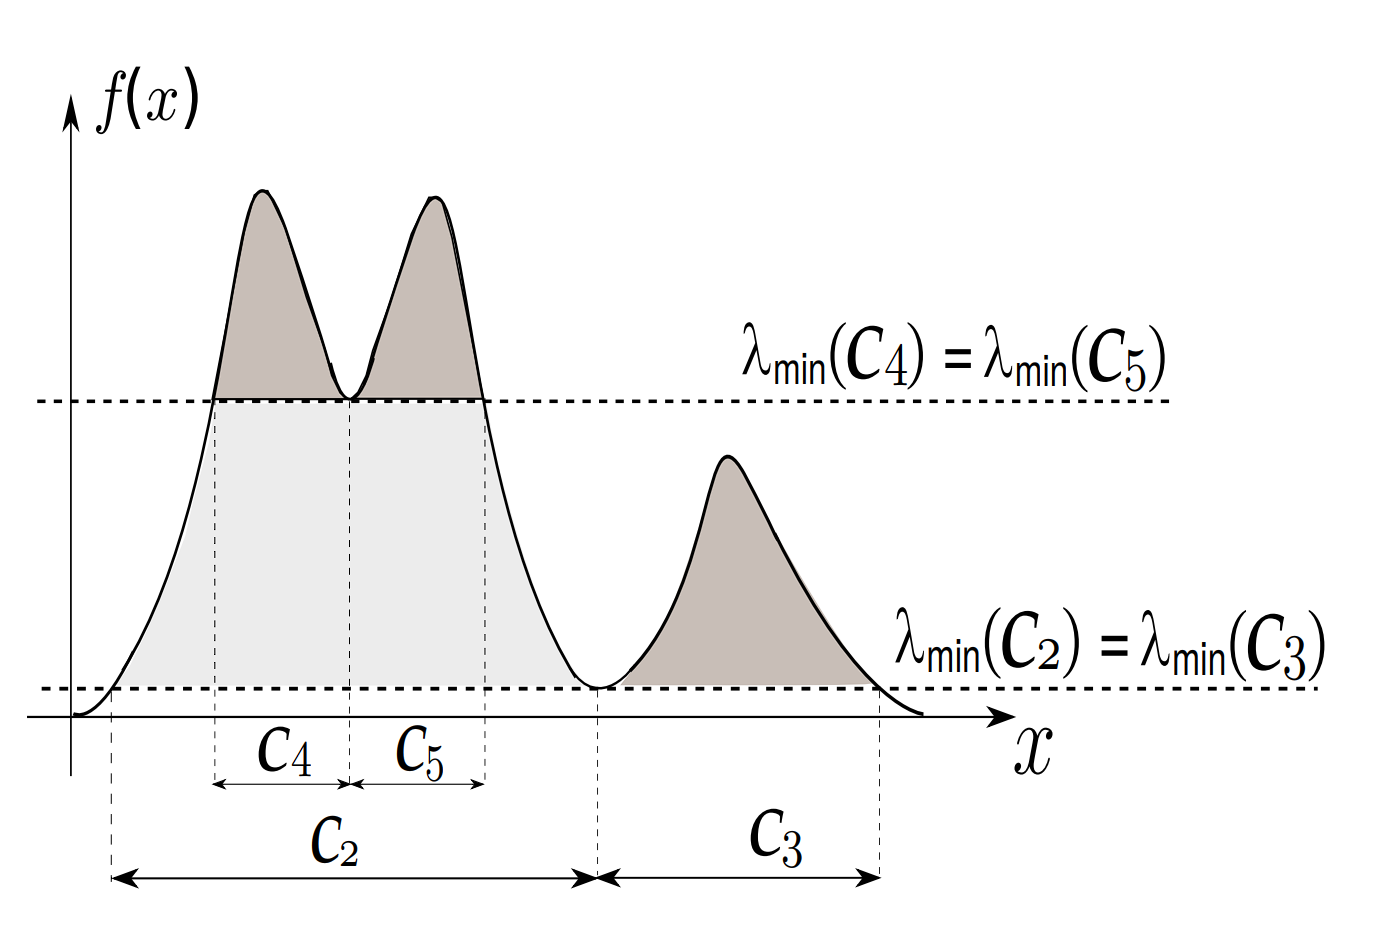

In [61]:

Image(filename = "density.png", width = 600, height = 400)

$\textbf{Figura 1}$ Ilustracion de la funcion de densidad, clusters y exceso de masa.

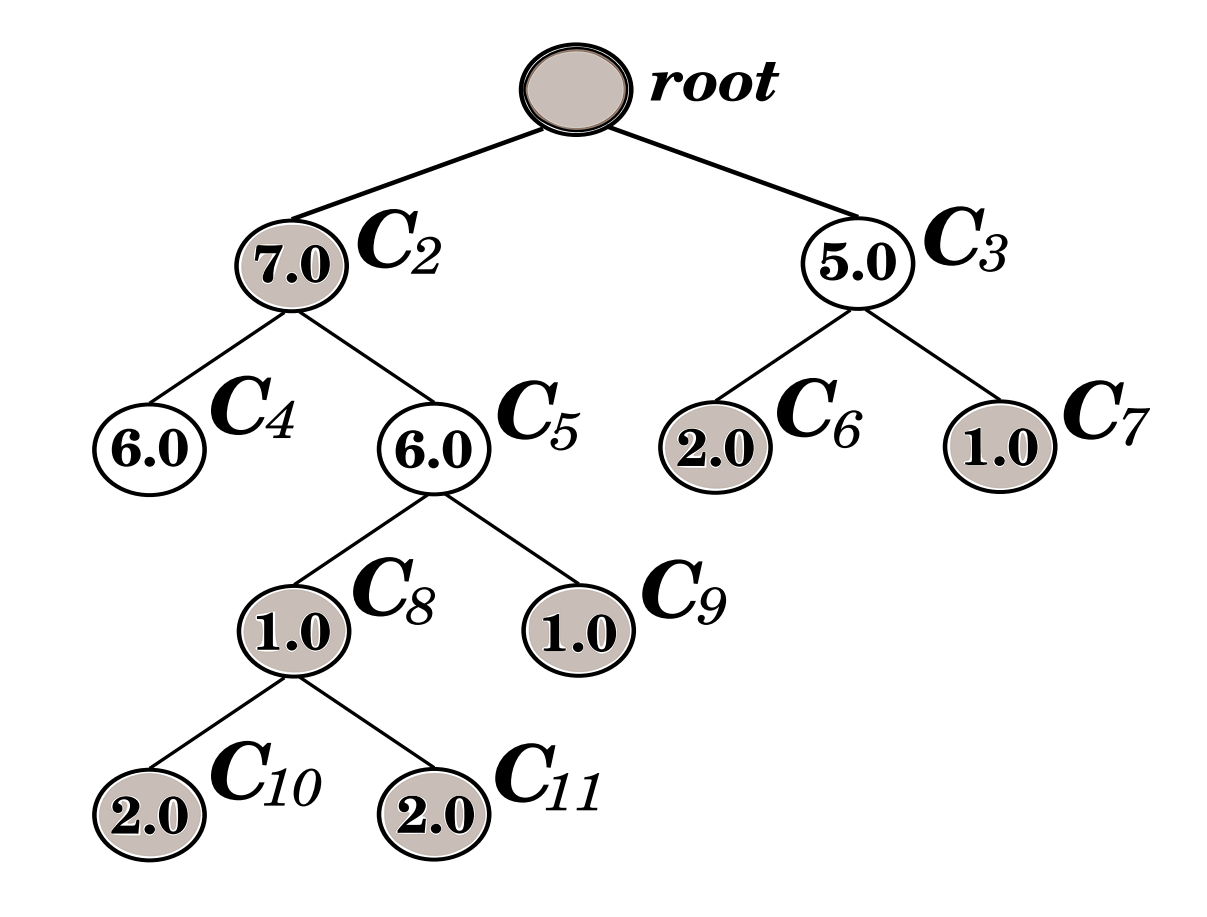

In [62]:
Image(filename = "tree.png", width = 600, height = 400)

$\textbf{Figura 2}$ Ilustracion de la seleccion optima de clusters para un árbol de cluster dado.

El exceso de masa exhibe un comportamiento monótono a lo largo de cualquier rama del árbol de conglomerados jerárquicos. Como consecuencia, esta medida no se puede utilizar para comparar las estabilidades de los clústeres anidados, como $\textbf{C}_2$ contra $\textbf{C}_4$ y $\textbf{C}_5$. Con el fin de realizar esta comparacion, se introduce la nocion de *exceso de masa relativo* para un cluster $\textbf{C}_i$ el cual aparece al nivel de densidad $\lambda_{min}\left(\textbf{C}_i\right)$ como:

\begin{align}
    	E_R\left(\textbf{C}_i\right) = \int_{x \in \textbf{C}_i} \left(\lambda_{max}\left(x,\textbf{C}_i\right)- \lambda_{min}\left(\textbf{C}_i\right)\right)dx
\end{align}

Donde $\lambda_{max}\left(x,\textbf{C}_i\right)= \text{min}\left\{f\left(x\right), \lambda_{max}\left(\textbf{C}_i\right)\right\}$ y $\lambda_{max}\left(\textbf{C}_i\right)$ es el nivel de densidad para el cual $\textbf{C}_i$ se divide o desaparece, e.g., para el cluster $\textbf{C}_2$ en la Figura 1 se puede deducir que $\lambda_{max}\left(\textbf{C}_2\right)=\lambda_{min}\left(\textbf{C}_4\right)=\lambda_{min}\left(\textbf{C}_5\right)$. Así se puede apreciar que el exceso de masa realitvo esta representado por el área sombreada más clara en la Figura 1.

Para el caso de la vida real cuando se tiene un conjunto de datos $\textbf{X}$ limitado, se propone adaptar la Ecuacion 2 con el fin de obtener una forma empirica de medir la estabilidad del cluster $\textbf{C}_i$. Teniendo asi el siguiente resultado:

\begin{align}
    	S\left(\textbf{C}_i\right) &= \sum_{x_j \in \textbf{C}_i} \left(\lambda_{max}\left(x,\textbf{C}_i\right)- \lambda_{min}\left(\textbf{C}_i\right)\right) \\
		&= \sum_{x_j \in \textbf{C}_i} \left(\frac{1}{\varepsilon_{min}\left(\textbf{x}_j, \textbf{C}_i\right)} - \frac{1}{\varepsilon_{max}\left(\textbf{C}_i\right)}\right)
\end{align}

Donde $\lambda_{min}\left(\textbf(C)_i\right)$ es el nivel de densidad minima para el cual $\textbf{C}_i$ existe, $\lambda_{max}\left(\textbf{x}_j,\textbf{C}_i\right)$ es el nivel de densidad a partir del cual el objeto $\textbf{x}_j$ deja de pertenecer al grupo $\textbf{C}_i$, y $\varepsilon_{max}\left(\textbf{C}_i\right)$ y $\varepsilon_{min}\left(\textbf{x}_j,\textbf{C}_i\right)$ son los valores correspondientes al valor de umbral $\varepsilon$ para cada caso.


## Implementacion

## Ejemplos de aplicacion  

## Ejercicios para el Lector

## Referencias

1. Campello, R.J.G.B., Moulavi, D., Sander, J. (2013). Density-Based Clustering Based on Hierarchical Density Estimates. In: Pei, J., Tseng, V.S., Cao, L., Motoda, H., Xu, G. (eds) Advances in Knowledge Discovery and Data Mining. PAKDD 2013. Lecture Notes in Computer Science(), vol 7819. Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-37456-2_14
2. L. McInnes and J. Healy, "Accelerated Hierarchical Density Based Clustering," 2017 IEEE International Conference on Data Mining Workshops (ICDMW), 2017, pp. 33-42, doi: 10.1109/ICDMW.2017.12.
3. Hastie, Trevor, Robert Tibshirani, and Jerome Friedman. The elements of statistical learning: data mining, inference, and prediction. Springer Science & Business Media, 2009.
4. https://hdbscan.readthedocs.io/en/latest/parameter_selection.html